# Chapter 1: Image Recognizer


This notebook will be my own attempt at chapter 1s bird image recognizer. The only difference is that I will be using pictures of Joe Biden and Donald Trump and having it determine which one is which.

The basic steps I will take to accomplish this are:

1. Use duck duck go to search for images of Donald Trump.
2. Use duck duck go to search for images of Joe Biden.
3. Fine-tune a pretrained neural network to recognize these two people.
4. Try running this model on a picture of Joe Biden to see if it works.

# Step 1: Download images of Donald Trump

In [30]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200):
  results = DDGS().images(keywords, max_results=max_images)

  # L is a special list feature in fastcore that
  # allows you to have special methods on it.

  # itemgot is basically equivalent to doing:
  # [d['image'] for d in results]
  return L(results).itemgot('image')


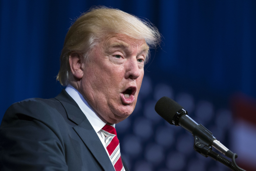

In [31]:
# Test the connection to ddg
urls = search_images('Donald Trump', max_images=1)

from fastdownload import download_url

dest = 'donald_trump.jpg'
download_url(urls[0], dest)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256, 256)


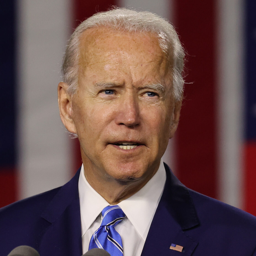

In [32]:
# Now the same but for Joe

urls = search_images('Joe Biden', max_images=1)

dest = 'joe_biden.jpg'
download_url(urls[0], dest)

im = Image.open(dest)
im.to_thumb(256, 256)


In [33]:
# Now we will create our data set

searches = 'Donald Trump', 'Joe Biden'
path = Path('presidents')

from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(parents=True, exist_ok=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

/home/leighton/projects/fastai/chapter-1/image-recognition/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [34]:
# Remove failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

23

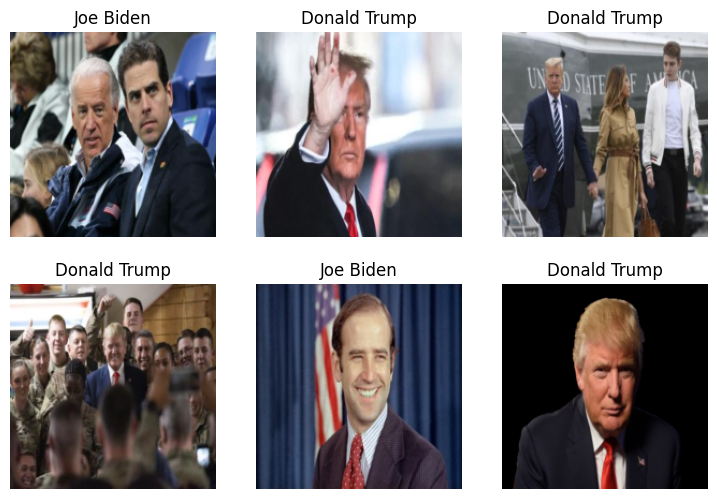

In [35]:
# Now we will use a data loader to create a training set & validation set
dls = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

# Observations

It is honestly hilarious how bad the results are from that test. I did not think about making sure my images were actually photos of the presidents. I should make sure that the images I am using are actually photos of the presidents.

Let's clean some of the images up and make sure that they are actually photos of the presidents.

# Step 2: Clean up the images



In [36]:
# Delete the presidents folder
import os
os.system(f'rm -rf {path} donald_trump.jpg joe_biden.jpg')

0

In [37]:
# With more specific search terms, we should be able to get better results.

searchs = {
  'Donald_Trump': 'Donald Trump photo',
  'Joe_Biden': 'Joe Biden photo'
}

for o in searchs:
  dest = (path/o)
  dest.mkdir(parents=True, exist_ok=True)
  download_images(dest, urls=search_images(f'{o} photo', max_images=10))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

# Verify failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

print("You may want to review images in the presidents folder to make sure they are actually photos of the presidents.")

# I only had to manually remove 1 image.


You may want to review images in the trump_biden folder to make sure they are actually photos of the presidents.


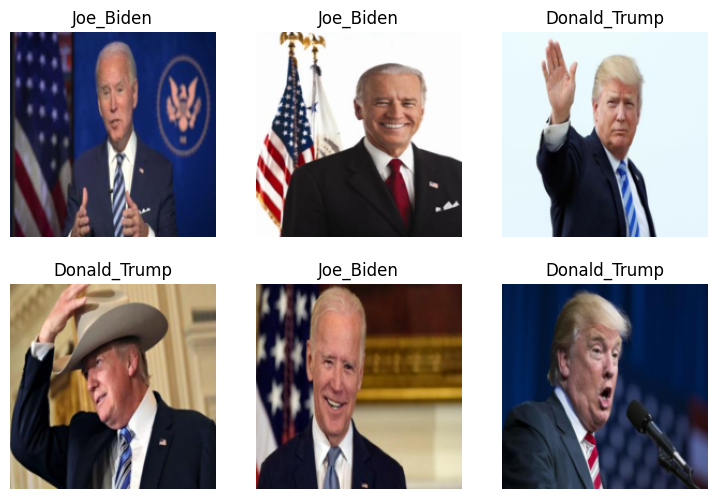

In [41]:
# Now again with the data loader

dls = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=6)

dls.show_batch(max_n=6)

# Observations

The results are looking much better. Now let's fine-tune a pretrained model.

In [42]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/leighton/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.1MB/s]


epoch     train_loss  valid_loss  error_rate  time    
0         0.837205    7.173605    1.000000    00:01                                    
epoch     train_loss  valid_loss  error_rate  time    
0         0.387533    5.804612    0.666667    00:00                                    
1         0.325904    4.687031    0.666667    00:00                                    
2         0.218444    3.889304    0.666667    00:00                                    


# Observations

I think this may mean that we need more images, I am going to try to download around 20 more images of each president and manually review them for accuracy.

In [43]:
# Delete the presidents folder
import os
os.system(f'rm -rf {path}')

# Step 3: Download more images
for o in searchs:
  dest = (path/o)
  dest.mkdir(parents=True, exist_ok=True)
  download_images(dest, urls=search_images(f'{o} photo', max_images=100))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

# Verify failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

print("You may want to review images in the presidents folder to make sure they are actually photos of the presidents.")

You may want to review images in the presidents folder to make sure they are actually photos of the presidents.


After sorting through all of the meme images for Donald Trump, I was left with 61 images. I think this is a better number than before.

Unfortunately, Joe had a lot more I had to filter out where it was just a random edited image of Joe Biden. I was left with 49 images.

I don't like the number for Joe, but I'm going to tread ahead anyway.

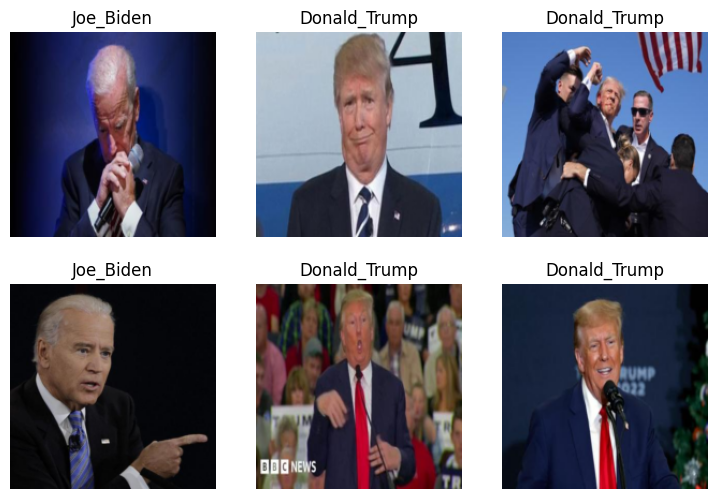

In [44]:
# Now again with the data loader

dls = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=6)

dls.show_batch(max_n=6)

In [45]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch     train_loss  valid_loss  error_rate  time    
0         1.049109    0.750010    0.454545    00:01                                      
epoch     train_loss  valid_loss  error_rate  time    
0         1.219053    0.526331    0.181818    00:01                                      
1         0.901467    0.580002    0.272727    00:01                                      
2         0.710285    0.639340    0.272727    00:01                                      


# Observations

So we made a good improvement. For fun, I want to see how it does on prediction.

I want to test with some actual pictures of the presidents, so we will download them from Wikipedia.

In [58]:
donald_trump_wiki_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Donald_Trump_official_portrait.jpg/1024px-Donald_Trump_official_portrait.jpg'
download_images(f'{path}/donald_trump', urls=[donald_trump_wiki_url], preserve_filename=true)

joe_biden_wiki_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Joe_Biden_presidential_portrait.jpg/1024px-Joe_Biden_presidential_portrait.jpg'
download_images(f'{path}/joe_biden', urls=[joe_biden_wiki_url], preserve_filename=true)
 
# Rename the images to the presidents name
os.system(f'mv {path}/donald_trump/1024px-Donald_Trump_official_portrait.jpg {path}/donald_trump/donald_trump.jpg')
os.system(f'mv {path}/joe_biden/1024px-Joe_Biden_presidential_portrait.jpg {path}/joe_biden/joe_biden.jpg')

is_donald_trump,_,probs = learn.predict(PILImage.create('presidents/donald_trump/donald_trump.jpg'))
print(f"This is {is_donald_trump} with confidence {probs[0]:.4f}")

is_joe_biden,_,probs = learn.predict(PILImage.create('presidents/joe_biden/joe_biden.jpg'))
print(f"This is {is_joe_biden} with confidence {probs[0]:.4f}")

This is Donald_Trump with confidence 0.6721                          
This is Joe_Biden with confidence 0.0003                             


# Observations

Not very good results here, but still 60% confidence on Donald Trump I think just comes down to having better images to train on.

I think if I had 100 high quality portraits of each president, I would get better results.